In [1]:
import pandas as pd
import os
import geopandas as gpd
from copy import deepcopy

In [2]:
def dfps_svi(dfps_df, svi=True, dfps_crosswalk='/Users/kpierce/demographic-toolkit/DFPSRegion_County_Crosswalk.csv'):
    
    # infer DFPS regions from counties
    dfps_cw = pd.read_csv(dfps_crosswalk, dtype={'fips': str})
    
    dfps_df = pd.merge(dfps_df, dfps_cw, left_on='GEOID', right_on='fips')
    
    # aggregate estimate columns
    agg_columns = [i for i in dfps_df.columns if 'E_' in i]
    
    dfps_df = dfps_df.groupby('DFPS_Region')[agg_columns].sum().reset_index()
    
    # SVI estimates and percents
    if svi:
        svi_map = {'EP_DISABL': 'E_DISABL', 'EP_MOBILE': 'E_MOBILE', 'EP_NOHSDP': 'E_NOHSDP',
              'EP_NOVEH': 'E_NOVEH', 'EP_POV': 'E_POV', 'EP_UNEMP': 'E_UNEMP',
              'EP_UNINSUR': 'E_UNINSUR', 'EP_CROWD': 'E_CROWD', 'EP_LIMENG': 'E_LIMENG'}
    
        # recalculate percentage columns
        for ep, e in svi_map.items():
            try:
                dfps_df[ep] = dfps_df[e] / dfps_df['E_TOTPOP']
            except KeyError:
                pass
    
    # clean up DFPS region names
    dfps_names = {
        1: '1-Lubbock',
        2: '2-Abilene',
        3: '3-Arlington',
        4: '4-Tyler',
        5: '5-Beaumont',
        6: '6-Houston',
        7: '7-Austin',
        8: '8-San Antonio',
        9: '9-Midland',
        10: '10-El Paso',
        11: '11-Edinburg'
    }
    
    dfps_df['GEOID'] = [dfps_names[i] for i in dfps_df['DFPS_Region']]
    
    # remove extraneous columns
    keep = [i for i in dfps_df.columns if i != "DFPS_Region"]
    dfps_df = dfps_df[keep]
    dfps_df['GEO_TYPE'] = 'dfps_region'
    
    return dfps_df


def zcta_svi(zcta_df, state='48'):
    
    zcta_df['state'] = [str(i)[0:2] if len(i) == 7 else None for i in zcta_df['GEOID']]
    zcta_df['GEOID'] = [str(i)[2:len(i)] if len(i) == 7 else i for i in zcta_df['GEOID']]
    zcta_df = zcta_df[zcta_df['state'] == state]
    zcta_df = zcta_df.drop('state', axis=1)
    
    return zcta_df
    
def aggregate_svi(year, cbg=None, zcta=None, urban=None, county=None, cbsa=None, tract=None, dfps=False):
    
    # load data, add year and geo type columns
    file_map = {'cbg': cbg, 'zcta': zcta, 'urban': urban, 'county': county, 'cbsa': cbsa, 'tract': tract}
    for geo, geo_file in file_map.items():
        if geo_file:
            geo_df = pd.read_csv(geo_file, dtype={'GEOID': str})
            geo_df['YEAR'] = year
            geo_df['GEO_TYPE'] = geo
            file_map[geo] = geo_df # replace path with data in mapping dictionary
    
    # tidy up and filter the ZCTAs
    if zcta and (year != '2019'):
        file_map['zcta'] = zcta_svi(file_map['zcta'])
    
    # dfps region data is derived from county data
    if dfps:
        dfps_df = deepcopy(file_map['county'])
        dfps_df = dfps_svi(dfps_df)
        dfps_df['YEAR'] = year
        file_map['dfps'] = dfps_df
        
    all_svi = pd.concat(file_map.values())
    return all_svi
    

In [3]:
svi_2011 = aggregate_svi(
    '2011',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2011_vars_feb2021_20210506191643.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2011_vars_feb2021_20210325094313.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2011_vars_feb2021_20210325105504.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2011_vars_feb2021_20210209180519.csv',
    dfps=True
    
)

svi_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2012_vars_feb2021_20210506191347.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2012_vars_feb2021_20210325101217.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2012_vars_feb2021_20210325094245.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2012_vars_feb2021_20210325105431.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2012_vars_feb2021_20210208232159.csv',
    dfps=True
    
)

svi_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2013_vars_feb2021_20210506191027.csv',
    urban='~/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2013_vars_feb2021_20210325101123.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2011_vars_feb2021_20210325094313.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2011_vars_feb2021_20210325105504.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2011_vars_feb2021_20210209180519.csv',
    dfps=True
    
)

svi_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2014_vars_feb2021_20210506190655.csv',
    urban='~/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2014_vars_feb2021_20210325101030.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2014_vars_feb2021_20210325094135.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2014_vars_feb2021_20210325105325.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2014_vars_feb2021_20210208231926.csv',
    dfps=True
    
)

svi_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2015_vars_feb2021_20210506190248.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2015_vars_feb2021_20210325100934.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2015_vars_feb2021_20210325094055.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2015_vars_feb2021_20210325105253.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2015_vars_feb2021_20210208231812.csv',
    dfps=True
    
)

svi_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2016_vars_feb2021_20210506185809.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2016_vars_feb2021_20210325100830.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2016_vars_feb2021_20210325094024.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2016_vars_feb2021_20210325105218.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2016_vars_feb2021_20210208231653.csv',
    dfps=True
    
)

svi_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2017_vars_feb2021_20210506185407.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2017_vars_feb2021_20210325100728.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2017_vars_feb2021_20210325093940.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2017_vars_feb2021_20210325105143.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2017_vars_feb2021_20210208231537.csv',
    dfps=True
    
)

svi_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2018_vars_feb2021_20210506185003.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2018_vars_feb2021_20210325100622.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2018_vars_feb2021_20210325093903.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2018_vars_feb2021_20210325105108.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2018_vars_feb2021_20210208231416.csv',
    dfps=True
    
)

svi_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2019_vars_feb2021_20210506193731.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2019_vars_feb2021_20210325100523.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2019_vars_feb2021_20210325093832.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2019_vars_feb2021_20210325105033.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2019_vars_feb2021_20210208231307.csv',
    dfps=True
    
)


In [4]:
svi_2012.head()

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,2254.0,1037.0,276.0,763.0,4.0,7001.0,8011.0,735.0,24.0,...,11.1,2.4,14.9,4.4,24.5,2012,zcta,NaN,NaN,NaN
27360,75002,20201.0,4063.0,241.0,4017.0,48.0,21082.0,21937.0,1735.0,141.0,...,4.7,1.6,5.6,5.8,13.7,2012,zcta,NaN,NaN,NaN
27361,75006,12057.0,4310.0,1173.0,3173.0,286.0,16710.0,17718.0,4995.0,110.0,...,24.5,3.9,13.2,7.2,28.0,2012,zcta,NaN,NaN,NaN
27362,75007,12947.0,4059.0,433.0,3598.0,33.0,18422.0,19294.0,3326.0,41.0,...,10.6,2.9,6.5,6.1,18.1,2012,zcta,NaN,NaN,NaN
27363,75009,2494.0,826.0,156.0,483.0,63.0,2752.0,3030.0,359.0,248.0,...,9.9,1.1,9.7,2.9,21.2,2012,zcta,NaN,NaN,NaN


In [5]:
svi_2013.head()

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,2055.0,1024.0,252.0,703.0,3.0,7379.0,8251.0,583.0,28.0,...,9.2,2.8,13.0,4.7,22.7,2013,zcta,NaN,NaN,NaN
27360,75002,20986.0,4305.0,366.0,3926.0,67.0,21340.0,22010.0,2115.0,175.0,...,5.2,1.1,7.1,6.4,15.3,2013,zcta,NaN,NaN,NaN
27361,75006,12376.0,4651.0,1398.0,3257.0,299.0,17075.0,18015.0,5515.0,106.0,...,25.3,3.8,14.7,7.2,28.9,2013,zcta,NaN,NaN,NaN
27362,75007,12906.0,4506.0,529.0,3595.0,23.0,18249.0,19107.0,3230.0,8.0,...,10.1,2.6,7.5,7.0,18.9,2013,zcta,NaN,NaN,NaN
27363,75009,2644.0,941.0,148.0,623.0,81.0,2924.0,3155.0,281.0,234.0,...,7.4,1.3,12.3,2.7,22.1,2013,zcta,NaN,NaN,NaN


In [6]:
svi_2014[svi_2014['GEO_TYPE'] == 'zcta']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,1888.0,1126.0,239.0,711.0,2.0,7906.0,8834.0,680.0,18.0,...,6.8,1.7,12.8,3.5,21.7,2014,zcta,NaN,NaN,NaN
27360,75002,20174.0,4629.0,338.0,4098.0,88.0,21569.0,22158.0,2057.0,99.0,...,5.3,1.0,7.9,6.1,14.0,2014,zcta,NaN,NaN,NaN
27361,75006,12426.0,4932.0,1310.0,3533.0,320.0,17101.0,18036.0,5790.0,118.0,...,24.6,3.6,14.7,6.5,29.9,2014,zcta,NaN,NaN,NaN
27362,75007,12961.0,4899.0,414.0,3598.0,14.0,18459.0,19201.0,2796.0,8.0,...,10.0,2.4,6.9,6.0,18.7,2014,zcta,NaN,NaN,NaN
27363,75009,2487.0,947.0,147.0,860.0,100.0,2981.0,3101.0,305.0,94.0,...,6.7,0.8,14.4,2.6,19.9,2014,zcta,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29289,79934,8332.0,866.0,177.0,1509.0,0.0,7219.0,7949.0,1244.0,226.0,...,9.6,2.1,8.0,6.9,14.4,2014,zcta,NaN,NaN,NaN
29290,79935,4348.0,2893.0,207.0,2559.0,580.0,6514.0,6921.0,1711.0,0.0,...,19.4,7.9,24.7,8.3,26.4,2014,zcta,NaN,NaN,NaN
29291,79936,32678.0,8325.0,1870.0,11396.0,409.0,34921.0,36497.0,10717.0,693.0,...,15.0,2.9,14.1,7.4,24.2,2014,zcta,NaN,NaN,NaN
29292,79938,22249.0,2697.0,990.0,5462.0,2284.0,16835.0,18260.0,7820.0,1818.0,...,21.6,2.2,19.9,7.7,26.7,2014,zcta,NaN,NaN,NaN


In [7]:
svi_2014[svi_2014['GEO_TYPE'] == 'tract']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,48001950100,1032.0,936.0,88.0,695.0,49.0,1853.0,2371.0,124.0,510.0,...,16.0,6.7,17.4,6.5,17.7,2014,tract,4.749056,2.546724,1232.0
1,48001950401,87.0,87.0,0.0,7.0,5567.0,99.0,106.0,163.0,0.0,...,26.5,5.1,32.4,13.4,3.3,2014,tract,0.000000,2.793488,3883.0
2,48001950402,28.0,143.0,0.0,39.0,5409.0,69.0,98.0,98.0,21.0,...,33.0,0.0,14.9,0.0,14.9,2014,tract,0.000000,1.754386,3833.0
3,48001950500,1452.0,615.0,127.0,623.0,94.0,1362.0,1610.0,292.0,8.0,...,20.8,4.8,34.0,8.7,33.2,2014,tract,9.324523,6.930928,2399.0
4,48001950600,1873.0,800.0,115.0,688.0,132.0,2184.0,2432.0,234.0,570.0,...,15.2,8.9,18.3,2.7,17.9,2014,tract,5.265568,3.928811,3295.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,48465980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2014,tract,NaN,NaN,NaN
5261,48469980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2014,tract,NaN,NaN,NaN
5262,48479980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2014,tract,NaN,NaN,NaN
5263,48485980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2014,tract,NaN,NaN,NaN


In [8]:
svi_2014[svi_2014['GEO_TYPE'] == 'cbg']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY


In [9]:
svi_2015[svi_2015['GEO_TYPE'] == 'tract']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,48001950100,1120.0,899.0,73.0,623.0,49.0,1784.0,2314.0,116.0,456.0,...,12.6,4.7,16.4,4.2,15.0,2015,tract,4.091928,2.578924,949.0
1,48001950401,85.0,55.0,0.0,9.0,4881.0,99.0,114.0,124.0,7.0,...,27.7,5.1,36.6,18.2,9.9,2015,tract,0.000000,2.407300,3443.0
2,48001950402,5.0,194.0,0.0,35.0,6664.0,53.0,79.0,101.0,24.0,...,33.1,0.0,18.1,0.0,18.1,2015,tract,0.000000,1.484857,4564.0
3,48001950500,1385.0,614.0,124.0,640.0,88.0,1492.0,1657.0,299.0,0.0,...,23.9,7.2,32.6,4.7,30.6,2015,tract,8.310992,7.083629,2538.0
4,48001950600,1938.0,823.0,145.0,653.0,93.0,2236.0,2479.0,287.0,487.0,...,15.8,9.4,17.8,4.0,20.7,2015,tract,6.484794,4.704918,3308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,48465980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,tract,NaN,NaN,NaN
5261,48469980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,tract,NaN,NaN,NaN
5262,48479980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,tract,NaN,NaN,NaN
5263,48485980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2015,tract,NaN,NaN,NaN


In [10]:
svi_2015[svi_2015['GEO_TYPE'] == 'zcta']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,1807.0,1177.0,229.0,653.0,0.0,8027.0,8983.0,739.0,25.0,...,5.8,1.8,10.0,4.1,19.7,2015,zcta,NaN,NaN,NaN
27360,75002,20695.0,4892.0,651.0,4548.0,106.0,22053.0,22414.0,2076.0,189.0,...,5.8,1.4,7.8,5.8,12.5,2015,zcta,NaN,NaN,NaN
27361,75006,12631.0,5168.0,1178.0,3563.0,337.0,17445.0,18153.0,5408.0,102.0,...,23.4,2.8,13.8,5.6,27.7,2015,zcta,NaN,NaN,NaN
27362,75007,12962.0,5362.0,448.0,3788.0,44.0,18759.0,19350.0,3100.0,51.0,...,11.0,2.3,7.4,5.5,17.6,2015,zcta,NaN,NaN,NaN
27363,75009,2637.0,1043.0,120.0,851.0,119.0,3009.0,3247.0,221.0,119.0,...,4.6,0.2,13.7,2.2,16.1,2015,zcta,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29289,79934,7945.0,1011.0,221.0,1735.0,0.0,7613.0,8521.0,1417.0,251.0,...,10.0,1.2,7.9,5.5,12.8,2015,zcta,NaN,NaN,NaN
29290,79935,4054.0,3144.0,229.0,2481.0,627.0,6463.0,6955.0,1718.0,53.0,...,18.8,6.9,22.7,6.6,26.0,2015,zcta,NaN,NaN,NaN
29291,79936,32887.0,8399.0,1594.0,11529.0,271.0,34861.0,36754.0,10341.0,806.0,...,14.0,2.8,14.5,6.5,21.4,2015,zcta,NaN,NaN,NaN
29292,79938,24659.0,2962.0,1017.0,6385.0,2224.0,18322.0,19972.0,8294.0,1702.0,...,20.9,2.3,19.1,6.9,24.6,2015,zcta,NaN,NaN,NaN


In [11]:
svi_2016[svi_2016['GEO_TYPE'] == 'tract']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,48001950100,1147.0,887.0,68.0,569.0,51.0,1767.0,2311.0,61.0,437.0,...,11.9,4.3,16.8,3.9,13.4,2016,tract,3.848331,1.393330,860.0
1,48001950401,80.0,38.0,0.0,9.0,4731.0,106.0,121.0,88.0,7.0,...,25.4,0.0,36.4,18.6,19.2,2016,tract,0.000000,1.751244,3376.0
2,48001950402,22.0,179.0,0.0,24.0,6989.0,79.0,123.0,50.0,21.0,...,30.8,0.0,19.6,0.0,0.0,2016,tract,0.000000,0.695120,4811.0
3,48001950500,1383.0,658.0,116.0,524.0,99.0,1582.0,1798.0,371.0,0.0,...,21.1,6.1,31.1,6.1,22.7,2016,tract,7.332491,8.429902,2629.0
4,48001950600,1878.0,786.0,174.0,593.0,93.0,2085.0,2404.0,267.0,372.0,...,15.1,10.0,15.9,3.3,18.8,2016,tract,8.345324,4.524657,3145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,48465980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,tract,NaN,NaN,NaN
5261,48469980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,tract,NaN,NaN,NaN
5262,48479980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,tract,NaN,NaN,NaN
5263,48485980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2016,tract,NaN,NaN,NaN


In [12]:
svi_2017[svi_2017['GEO_TYPE'] == 'zcta']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,1798.0,1088.0,239.0,466.0,0.0,8287.0,9315.0,670.0,0.0,...,4.3,1.4,8.6,4.4,17.5,2017,zcta,NaN,NaN,NaN
27360,75002,20580.0,5479.0,710.0,4893.0,119.0,22029.0,22532.0,2193.0,220.0,...,6.5,1.9,6.9,4.9,11.3,2017,zcta,NaN,NaN,NaN
27361,75006,13243.0,5509.0,1187.0,3538.0,365.0,17780.0,18451.0,6042.0,112.0,...,22.7,2.5,14.8,4.1,24.7,2017,zcta,NaN,NaN,NaN
27362,75007,12077.0,6276.0,460.0,4339.0,125.0,19109.0,19665.0,3039.0,58.0,...,10.7,2.3,7.8,4.0,15.5,2017,zcta,NaN,NaN,NaN
27363,75009,2696.0,1362.0,83.0,953.0,128.0,3532.0,3800.0,220.0,224.0,...,6.0,0.1,10.0,2.2,12.0,2017,zcta,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29289,79934,8144.0,1097.0,291.0,2644.0,0.0,8571.0,9694.0,1402.0,252.0,...,8.2,1.3,6.8,5.6,11.9,2017,zcta,NaN,NaN,NaN
29290,79935,3670.0,3293.0,130.0,2369.0,672.0,6242.0,6826.0,1841.0,62.0,...,17.8,5.7,16.6,5.4,23.8,2017,zcta,NaN,NaN,NaN
29291,79936,30894.0,9375.0,1632.0,11814.0,279.0,34781.0,37001.0,10510.0,765.0,...,14.3,3.5,14.3,5.5,18.2,2017,zcta,NaN,NaN,NaN
29292,79938,26769.0,2941.0,952.0,7283.0,2309.0,21340.0,23123.0,8448.0,1877.0,...,18.2,1.9,16.7,5.4,20.0,2017,zcta,NaN,NaN,NaN


In [13]:
svi_2017[svi_2017['GEO_TYPE'] == 'tract']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,48001950100,1274.0,890.0,121.0,537.0,52.0,1878.0,2489.0,101.0,547.0,...,11.5,4.6,16.9,2.9,13.5,2017,tract,6.443024,2.131701,1168.0
1,48001950401,122.0,50.0,3.0,9.0,4642.0,100.0,115.0,79.0,7.0,...,24.6,0.0,27.0,14.6,13.8,2017,tract,3.000000,1.594671,3263.0
2,48001950402,21.0,218.0,0.0,18.0,7119.0,128.0,182.0,35.0,45.0,...,29.5,0.0,22.9,0.0,6.8,2017,tract,0.000000,0.475027,4780.0
3,48001950500,1302.0,648.0,89.0,508.0,93.0,1652.0,1856.0,462.0,0.0,...,20.7,4.9,25.1,6.4,18.8,2017,tract,5.387409,10.550354,2773.0
4,48001950600,1788.0,823.0,80.0,701.0,91.0,1983.0,2345.0,298.0,259.0,...,25.2,11.3,11.2,4.6,17.9,2017,tract,4.034291,5.266879,2593.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,48453980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,tract,NaN,NaN,NaN
5261,48465980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,tract,NaN,NaN,NaN
5262,48469980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,tract,NaN,NaN,NaN
5263,48485980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2017,tract,NaN,NaN,NaN


In [14]:
svi_2018[svi_2018['GEO_TYPE'] == 'tract']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,48001950100,1368.0,1003.0,100.0,729.0,48.0,1846.0,2455.0,60.0,642.0,...,10.9,2.5,16.2,3.1,11.8,2018,tract,5.417118,1.250782,1045.0
1,48001950401,136.0,49.0,5.0,12.0,4575.0,81.0,96.0,36.0,8.0,...,25.4,0.0,1.0,0.0,21.5,2018,tract,6.172840,0.743494,3140.0
2,48001950402,28.0,223.0,0.0,5.0,7331.0,128.0,181.0,29.0,37.0,...,30.3,0.0,20.3,2.2,5.5,2018,tract,0.000000,0.384666,4945.0
3,48001950500,1243.0,620.0,96.0,569.0,79.0,1697.0,1914.0,454.0,34.0,...,19.5,7.7,21.1,5.3,19.9,2018,tract,5.657042,10.531199,2612.0
4,48001950600,1279.0,846.0,8.0,813.0,84.0,1876.0,2371.0,114.0,387.0,...,28.6,12.3,10.0,3.8,15.1,2018,tract,0.426439,2.132435,1902.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,48453980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,tract,NaN,NaN,NaN
5261,48465980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,tract,NaN,NaN,NaN
5262,48469980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,tract,NaN,NaN,NaN
5263,48485980000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2018,tract,NaN,NaN,NaN


In [15]:
svi_2018[svi_2018['GEO_TYPE'] == 'zcta']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,1886.0,1231.0,274.0,660.0,0.0,8361.0,9492.0,813.0,0.0,...,4.8,1.8,10.1,4.2,16.1,2018,zcta,NaN,NaN,NaN
27360,75002,20269.0,6210.0,514.0,5526.0,113.0,22236.0,23015.0,2377.0,238.0,...,5.9,1.9,6.3,4.4,9.0,2018,zcta,NaN,NaN,NaN
27361,75006,13163.0,5804.0,1101.0,3514.0,337.0,18022.0,18621.0,5566.0,116.0,...,21.1,2.8,12.5,4.1,22.9,2018,zcta,NaN,NaN,NaN
27362,75007,11889.0,6589.0,476.0,4486.0,165.0,19356.0,19911.0,2980.0,104.0,...,10.3,2.7,6.8,3.5,13.8,2018,zcta,NaN,NaN,NaN
27363,75009,3463.0,1312.0,122.0,986.0,120.0,3633.0,3963.0,480.0,218.0,...,10.0,1.0,6.4,2.1,15.7,2018,zcta,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29289,79934,8544.0,1198.0,318.0,2752.0,0.0,8917.0,10120.0,1232.0,233.0,...,7.6,2.2,8.8,4.6,10.0,2018,zcta,NaN,NaN,NaN
29290,79935,3576.0,3468.0,120.0,2508.0,647.0,6155.0,6709.0,1713.0,51.0,...,17.8,5.2,15.3,6.3,20.8,2018,zcta,NaN,NaN,NaN
29291,79936,29933.0,10374.0,1742.0,12072.0,251.0,35120.0,37263.0,10541.0,630.0,...,13.7,3.2,14.7,5.6,16.7,2018,zcta,NaN,NaN,NaN
29292,79938,27258.0,3144.0,922.0,8063.0,2330.0,22438.0,24392.0,7820.0,1767.0,...,16.9,2.1,15.9,5.5,18.4,2018,zcta,NaN,NaN,NaN


In [16]:
svi_2019[svi_2019['GEO_TYPE'] == 'zcta']

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
0,75001,2198.0,1115.0,362.0,14983.0,0.0,8129.0,9298.0,1033.0,0.0,...,4.6,1.9,10.9,4.2,17.0,2019,zcta,NaN,NaN,NaN
1,75002,19937.0,6951.0,457.0,71127.0,116.0,22414.0,23314.0,2564.0,280.0,...,5.5,2.1,4.9,4.9,8.6,2019,zcta,NaN,NaN,NaN
2,75006,12879.0,6060.0,1039.0,51281.0,338.0,18580.0,19178.0,5313.0,119.0,...,20.5,2.6,10.8,3.9,21.0,2019,zcta,NaN,NaN,NaN
3,75007,11659.0,6699.0,456.0,55500.0,205.0,19465.0,20000.0,3212.0,116.0,...,9.7,2.5,6.7,3.1,12.5,2019,zcta,NaN,NaN,NaN
4,75009,4359.0,1529.0,124.0,13947.0,120.0,4207.0,4568.0,505.0,279.0,...,9.8,0.7,4.0,1.4,16.7,2019,zcta,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,79934,8014.0,1328.0,366.0,24983.0,0.0,9206.0,10385.0,1046.0,236.0,...,7.1,2.0,7.5,3.4,10.4,2019,zcta,NaN,NaN,NaN
1931,79935,3707.0,3435.0,170.0,16940.0,671.0,6216.0,6706.0,1587.0,45.0,...,15.8,5.2,13.0,6.7,20.5,2019,zcta,NaN,NaN,NaN
1932,79936,29390.0,11590.0,1540.0,110026.0,239.0,35437.0,37267.0,10408.0,596.0,...,14.1,3.6,14.0,4.7,17.0,2019,zcta,NaN,NaN,NaN
1933,79938,28931.0,3459.0,896.0,79897.0,2325.0,23642.0,25710.0,7934.0,1837.0,...,16.4,1.9,13.9,5.4,18.3,2019,zcta,NaN,NaN,NaN


In [17]:
svi_2019.columns

Index(['GEOID', 'E_AGE17', 'E_AGE65', 'E_CROWD', 'E_DISABL', 'E_GROUPQ',
       'E_HH', 'E_HU', 'E_LIMENG', 'E_MOBILE', 'E_MUNIT', 'E_NOHSDP',
       'E_NOVEH', 'E_PCI', 'E_POV', 'E_SNGPNT', 'E_TOTPOP', 'E_UNEMP',
       'E_UNINSUR', 'EP_DISABL', 'EP_MOBILE', 'EP_NOHSDP', 'EP_NOVEH',
       'EP_POV', 'EP_UNEMP', 'EP_UNINSUR', 'YEAR', 'GEO_TYPE', 'EP_CROWD',
       'EP_LIMENG', 'E_MINRTY'],
      dtype='object')

In [68]:
#svi_2011.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2011_demographic_features.csv')
#svi_2012.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2012_demographic_features.csv')
#svi_2013.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2013_demographic_features.csv')
#svi_2014.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2014_demographic_features.csv')
#svi_2015.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2015_demographic_features.csv')
#svi_2016.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2016_demographic_features.csv')
#svi_2017.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2017_demographic_features.csv')
#svi_2018.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2018_demographic_features.csv')
#svi_2019.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/2019_demographic_features.csv')

# Commute Time Data

In [89]:
def commute_time_pct_bins(commute_df):
    
    minute_bins = [i for i in commute_df.columns if 'E_' in i]
    for b in minute_bins:
        b_split = '_'.join(b.split('_')[1:])
        bin_name = 'EP_{}'.format(b_split)
        commute_df[bin_name] = commute_df[b] / commute_df['TOTAL_COMMUTE_POP']
        
    commute_df['EP_30LESS_MIN'] = commute_df['EP_5LESS_MIN'] + commute_df['EP_5_9_MIN'] + commute_df['EP_10_14_MIN'] + commute_df['EP_15_19_MIN'] + commute_df['EP_20_24_MIN'] + commute_df['EP_25_29_MIN']
    commute_df['EP_30_60_MIN'] = commute_df['EP_30_34_MIN'] + commute_df['EP_35_39_MIN'] + commute_df['EP_40_44_MIN'] + commute_df['EP_45_59_MIN']
    commute_df['EP_60PLUS_MIN'] = commute_df['EP_60_89_MIN'] + commute_df['EP_90PLUS_MIN']
        
    return commute_df

In [93]:
commute_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_zcta_vars_may2021_20210506034726.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_urban_area_vars_may2021_20210506034629.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_county_vars_may2021_20210506034350.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506034409.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_tract_vars_may2021_20210506034559.csv',
    dfps=True
)

commute_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_zcta_vars_may2021_20210506030313.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_urban_area_vars_may2021_20210506030216.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_county_vars_may2021_20210506025946.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506030003.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_tract_vars_may2021_20210506030150.csv',
    dfps=True
)

commute_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_zcta_vars_may2021_20210506025841.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_urban_area_vars_may2021_20210506025743.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_county_vars_may2021_20210506025501.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506025518.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_tract_vars_may2021_20210506025716.csv',
    dfps=True
)

commute_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_zcta_vars_may2021_20210506021428.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_urban_area_vars_may2021_20210506021332.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_county_vars_may2021_20210506021059.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506021121.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_tract_vars_may2021_20210506021307.csv',
    dfps=True
)

commute_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_zcta_vars_may2021_20210506013017.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_urban_area_vars_may2021_20210506012919.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_county_vars_may2021_20210506012644.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506012702.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_tract_vars_may2021_20210506012852.csv',
    dfps=True
)

commute_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_zcta_vars_may2021_20210506004543.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_urban_area_vars_may2021_20210506004445.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_county_vars_may2021_20210506004220.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506004239.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_tract_vars_may2021_20210506004420.csv',
    dfps=True
)

commute_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_zcta_vars_may2021_20210506000308.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_urban_area_vars_may2021_20210506000157.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_county_vars_may2021_20210505235920.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505235939.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_tract_vars_may2021_20210506000130.csv',
    dfps=True
)

commute_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_zcta_vars_may2021_20210505231951.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_urban_area_vars_may2021_20210505231847.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_county_vars_may2021_20210505231614.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505231632.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_tract_vars_may2021_20210505231821.csv',
    dfps=True
)

commute_2011 = aggregate_svi(
    '2011',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_zcta_vars_may2021_20210505231505.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_urban_area_vars_may2021_20210505231403.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_county_vars_may2021_20210505231130.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505231150.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_tract_vars_may2021_20210505231337.csv',
    dfps=True
)

In [94]:
c2019 = commute_time_pct_bins(commute_2019)
c2018 = commute_time_pct_bins(commute_2018)
c2017 = commute_time_pct_bins(commute_2017)
c2016 = commute_time_pct_bins(commute_2016)
c2015 = commute_time_pct_bins(commute_2015)
c2014 = commute_time_pct_bins(commute_2014)
c2013 = commute_time_pct_bins(commute_2013)
c2012 = commute_time_pct_bins(commute_2012)
c2011 = commute_time_pct_bins(commute_2011)

In [87]:
c2019.head()

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,...,EP_40_44_MIN,EP_45_59_MIN,EP_5_9_MIN,EP_5LESS_MIN,EP_60_89_MIN,EP_90PLUS_MIN,EP_COMMUTE_POP,EP_30LESS_MIN,EP_30_60_MIN,EP_60PLUS_MIN
0,00601,464,741,240,63,513,134,111,403,363,...,0.031678,0.115011,0.103596,0.050799,0.035959,0.047945,0.000285,0.584760,0.331336,0.083904
1,00602,1286,1942,929,1396,712,797,270,537,1577,...,0.025653,0.051021,0.149834,0.070879,0.005891,0.025748,0.000095,0.748314,0.220048,0.031639
2,00603,2030,3175,1537,308,795,81,248,436,1480,...,0.021605,0.037982,0.128931,0.056712,0.037895,0.026396,0.000087,0.799808,0.135900,0.064291
3,00606,547,38,38,8,161,9,69,59,228,...,0.056189,0.048046,0.185668,0.004886,0.045603,0.007329,0.000814,0.704397,0.242671,0.052932
4,00610,1211,1347,689,1031,431,720,254,280,1499,...,0.031494,0.034718,0.185865,0.041662,0.028642,0.004464,0.000124,0.757967,0.208927,0.033106


In [70]:
commute_2019.head()

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,E_5LESS_MIN,E_60_89_MIN,E_90PLUS_MIN,TOTAL_COMMUTE_POP,YEAR,GEO_TYPE
0,00601,464,741,240,63,513,134,111,403,363,178,126,168,3504,2019,zcta
1,00602,1286,1942,929,1396,712,797,270,537,1577,746,62,271,10525,2019,zcta
2,00603,2030,3175,1537,308,795,81,248,436,1480,651,435,303,11479,2019,zcta
3,00606,547,38,38,8,161,9,69,59,228,6,56,9,1228,2019,zcta
4,00610,1211,1347,689,1031,431,720,254,280,1499,336,231,36,8065,2019,zcta


In [72]:
commute_2018.head()

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,E_5LESS_MIN,E_60_89_MIN,E_90PLUS_MIN,TOTAL_COMMUTE_POP,YEAR,GEO_TYPE
27359,75001,1552.0,1441.0,1734.0,883.0,1661.0,252.0,425.0,498.0,1151.0,261.0,155.0,93.0,10106.0,2018,zcta
27360,75002,3517.0,4469.0,4225.0,2702.0,4728.0,1079.0,1670.0,4361.0,2210.0,992.0,2768.0,539.0,33260.0,2018,zcta
27361,75006,3736.0,4314.0,4099.0,2395.0,4433.0,634.0,780.0,1571.0,1942.0,324.0,750.0,282.0,25260.0,2018,zcta
27362,75007,2832.0,4665.0,4797.0,2822.0,5441.0,1138.0,1219.0,2406.0,1736.0,305.0,753.0,379.0,28493.0,2018,zcta
27363,75009,440.0,317.0,542.0,350.0,1114.0,337.0,223.0,886.0,460.0,150.0,464.0,151.0,5434.0,2018,zcta


In [95]:
#c2019.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2019_binned_commute_times.csv')
#c2018.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2018_binned_commute_times.csv')
#c2017.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2017_binned_commute_times.csv')
#c2016.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2016_binned_commute_times.csv')
#c2015.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2015_binned_commute_times.csv')
#c2014.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2014_binned_commute_times.csv')
#c2013.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2013_binned_commute_times.csv')
#c2012.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2012_binned_commute_times.csv')
#c2011.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data/2011_binned_commute_times.csv')


# May Demo: choropleth maps of commute time

- county
- zcta
- urban area
- dfps region

In [125]:
import matplotlib.pyplot as plt

In [196]:
county_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_counties/texas_counties.shp')
zcta_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_zcta/texas_zcta_2019.shp')
urban_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_urban_areas/texas_urban_areas.shp')
dfps_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_dfps_regions/dfps_regions.shp')
tract_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_census_tracts/census_tracts_2019.shp')

In [187]:
def commute_choropleth(data_df, shp_df, geo_type, data_col='GEOID', shp_col='GEO_ID', plot=True):
    
    clean_data_df = data_df[data_df['GEO_TYPE'] == geo_type]
    geo_shp_data = gpd.GeoDataFrame(
        pd.merge(clean_data_df, shp_df, left_on=data_col, right_on=shp_col, how='inner'),
        crs=shp_df.crs
    )
    
    # add 0 and 1 to enforce legend labeling
    dummy_zeros = pd.DataFrame.from_dict([{
        col:(0 if col!='geometry' else None) for col in geo_shp_data.columns
    }])

    dummy_ones = pd.DataFrame.from_dict([{
        col:(1 if col!='geometry' else None) for col in geo_shp_data.columns
    }])

    geo_shp_data = pd.concat([geo_shp_data, dummy_zeros, dummy_ones])
    
    # make figure
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(30, 10))

        geo_shp_data.plot(column='EP_30LESS_MIN', ax=ax[0], legend=False, cmap='YlOrRd', )
        geo_shp_data.plot(column='EP_30_60_MIN', ax=ax[1], legend=False, cmap='YlOrRd')
        geo_shp_data.plot(column='EP_60PLUS_MIN', ax=ax[2], legend=False, cmap='YlOrRd')

        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[2].set_axis_off()

        ax[0].set_title('Commute <30 min', fontsize=40)
        ax[1].set_title('Commute 30-59 min', fontsize=40)
        ax[2].set_title('Commute >60 min', fontsize=40)

        cax = fig.add_axes([1, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbr = fig.colorbar(sm, cax=cax,)
        cbr.ax.tick_params(labelsize=20) 
        plt.tight_layout()
    
    return geo_shp_data

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


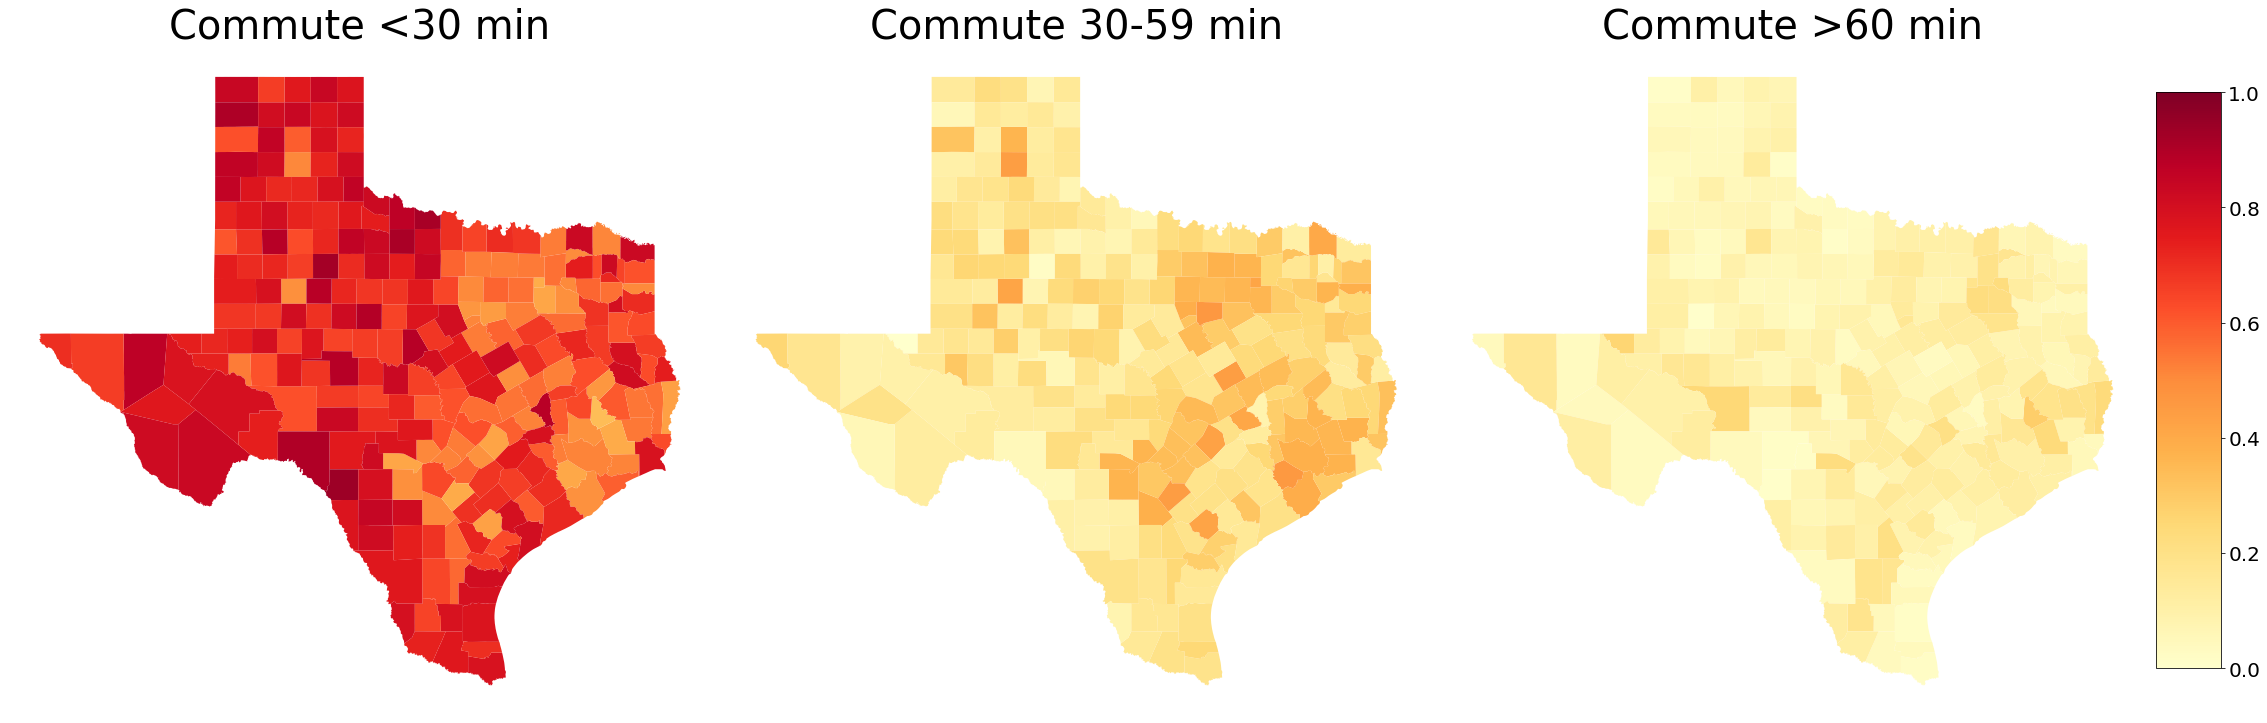

In [188]:
county_commute_shp = commute_choropleth(data_df=c2019, shp_df=county_shp, geo_type='county')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


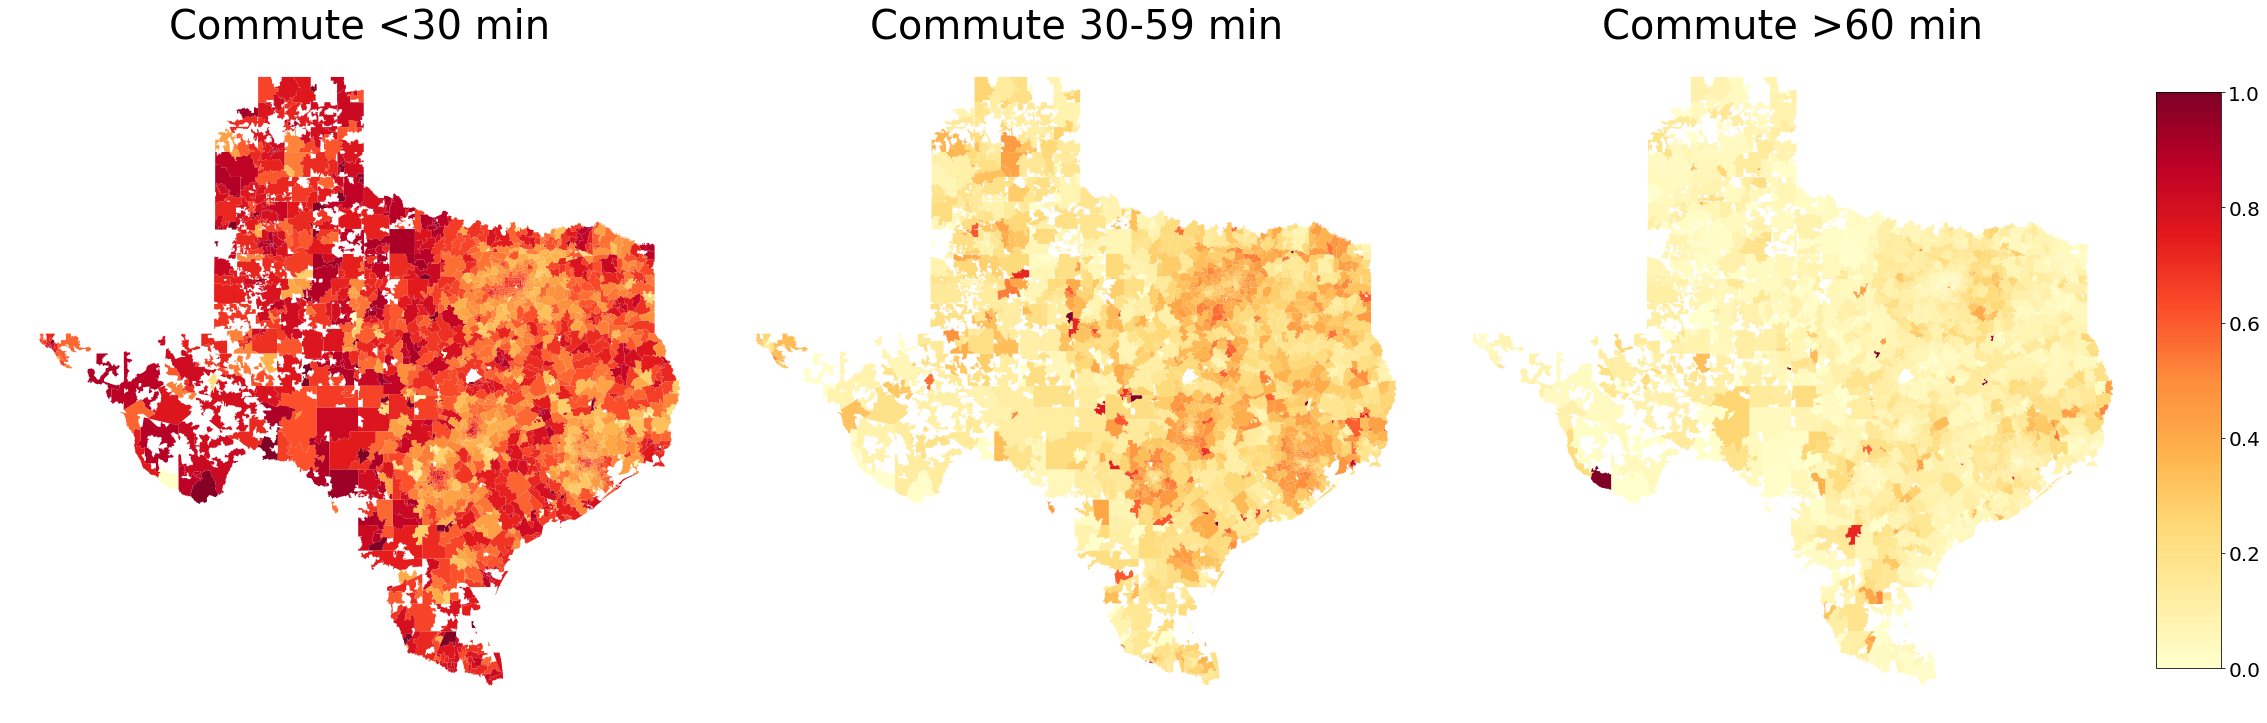

In [191]:
zcta_commute_shp = commute_choropleth(data_df=c2019, shp_df=zcta_shp, geo_type='zcta', shp_col='GEOID10')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


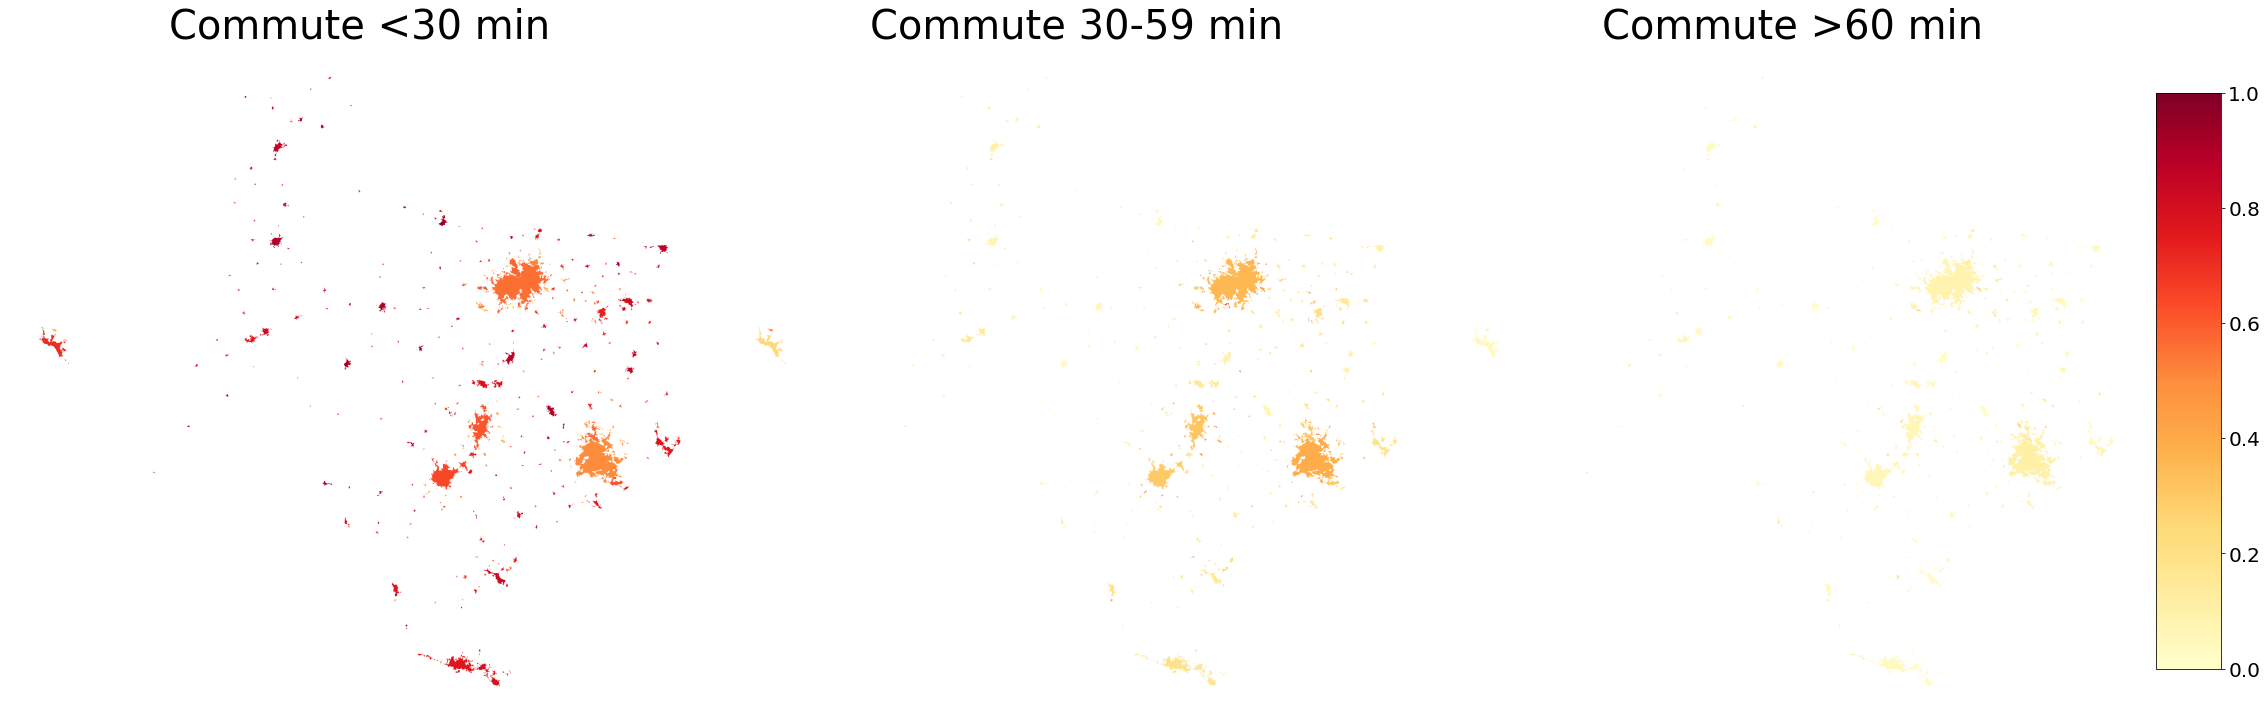

In [194]:
urban_commute_shp = commute_choropleth(data_df=c2019, shp_df=urban_shp, geo_type='urban', shp_col='GEOID10')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


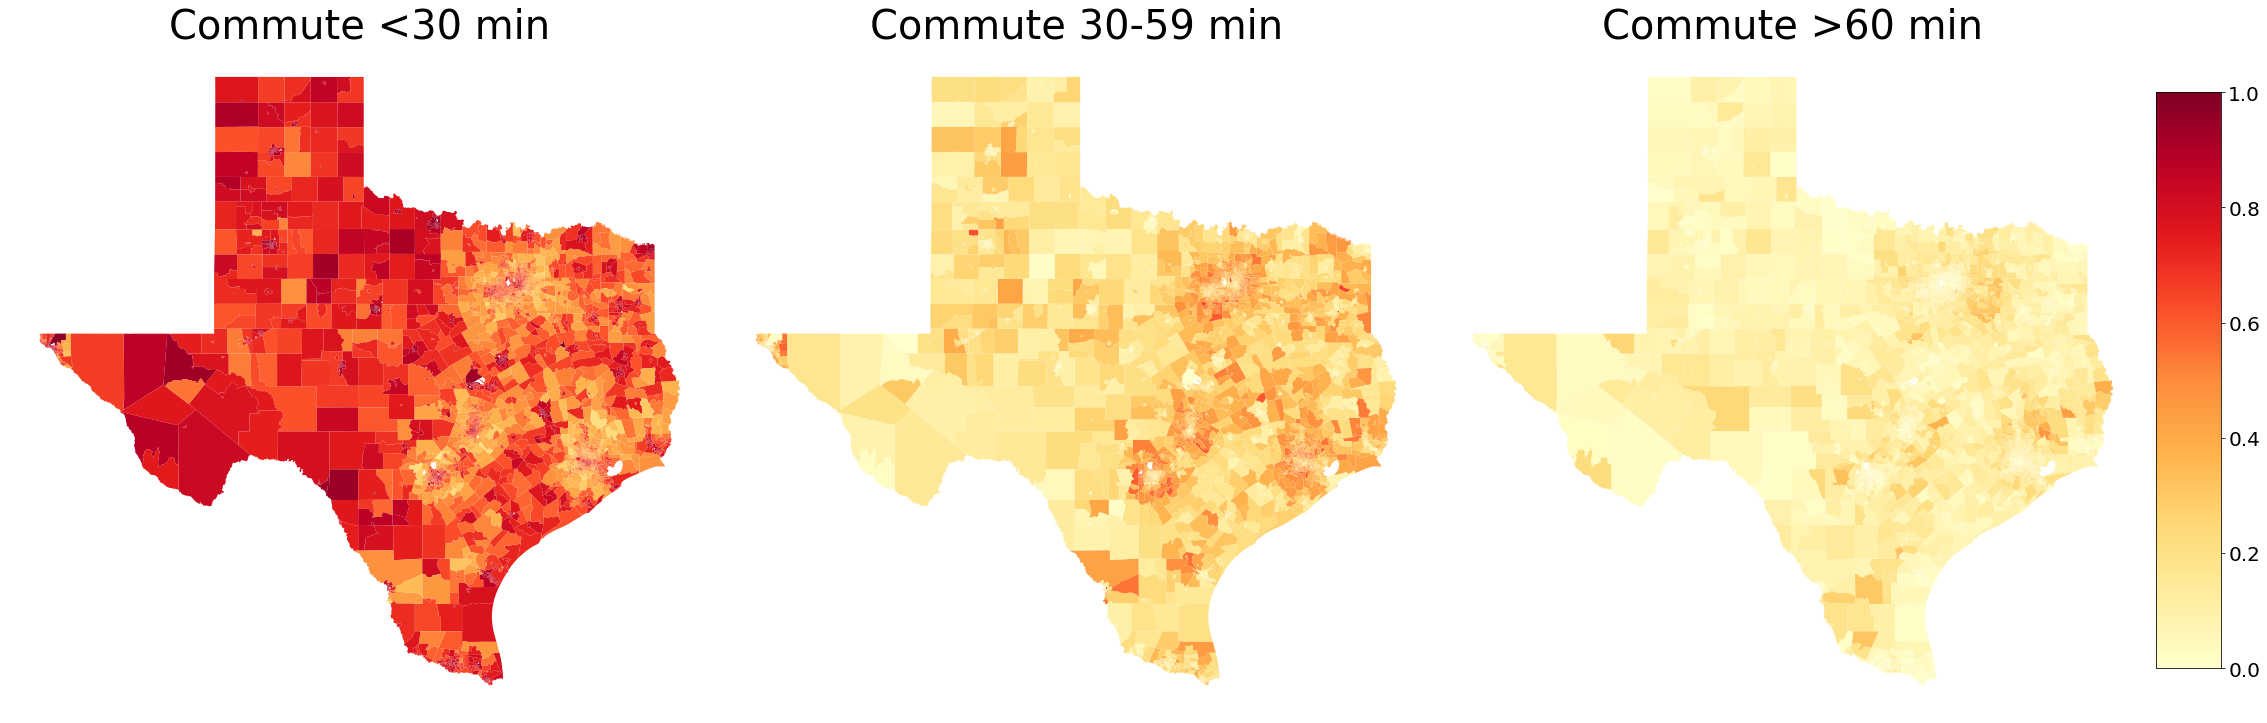

In [198]:
tract_commute_shp = commute_choropleth(data_df=c2019, shp_df=tract_shp, geo_type='tract', shp_col='GEOID')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


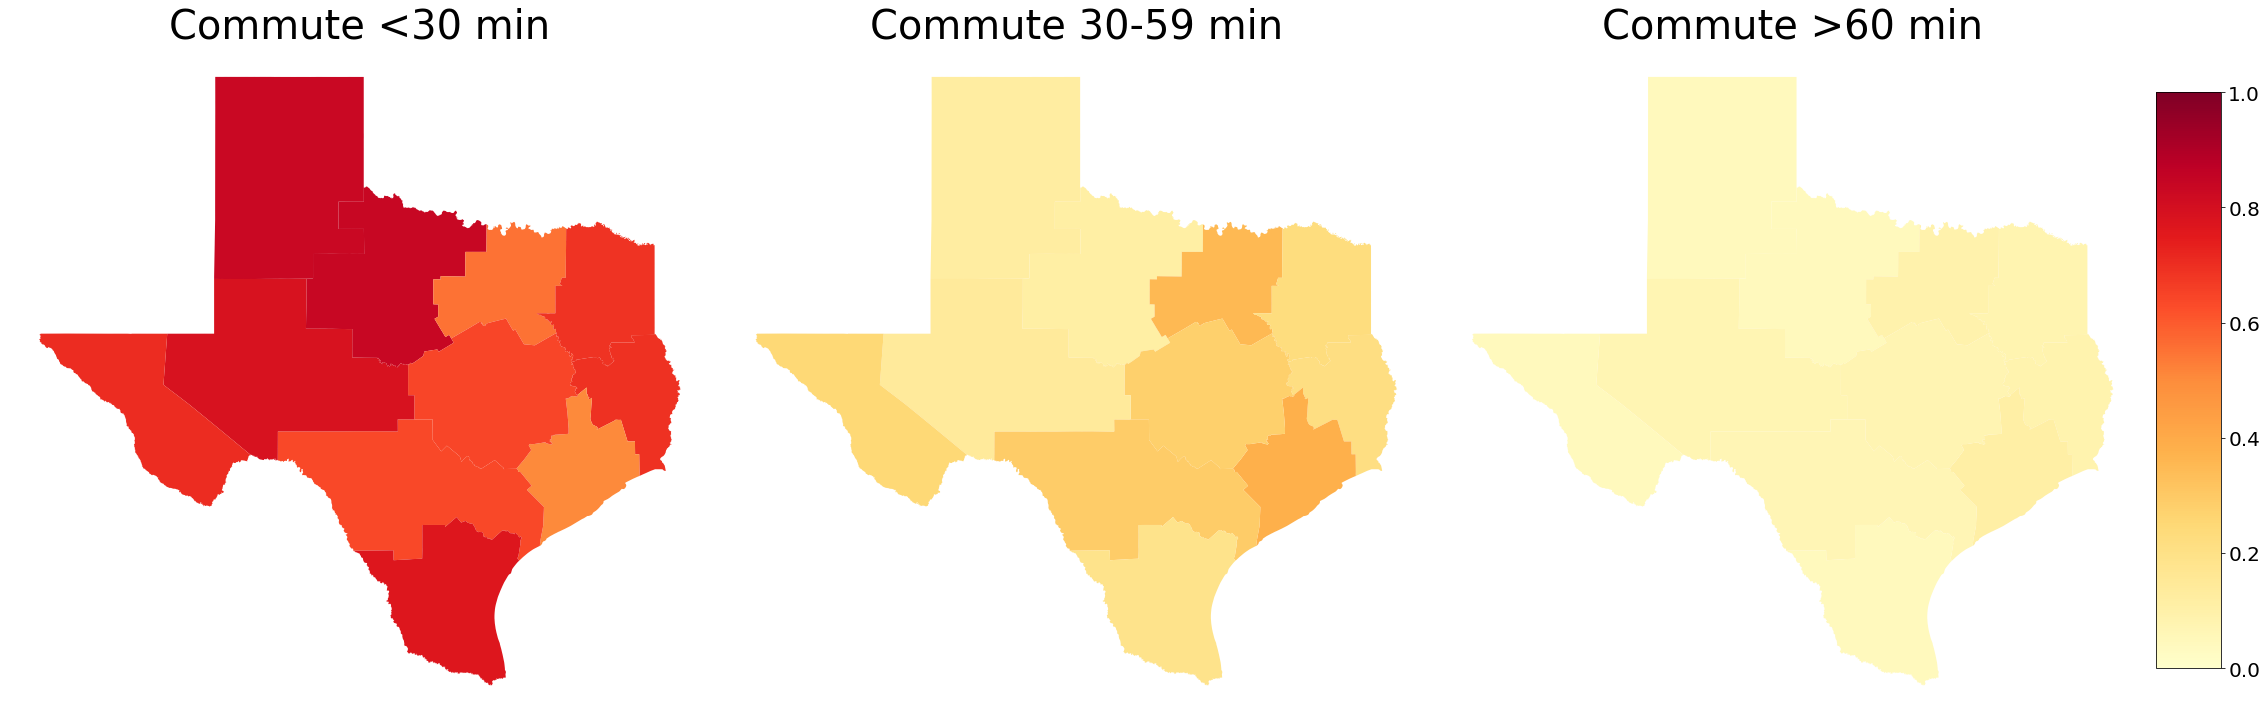

In [203]:
dfps_commute_shp = commute_choropleth(data_df=c2019, shp_df=dfps_shp, geo_type='dfps_region', shp_col='Sheet1__Re')

# Variables inspired by Opportunity Atlas

In [17]:
opportunity_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_zcta_other_census_vars_may2021_20210520143725.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_urban_area_other_census_vars_may2021_20210520143638.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_county_other_census_vars_may2021_20210520143028.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520143147.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_tract_other_census_vars_may2021_20210520143534.csv',
    dfps=True
)

opportunity_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_zcta_other_census_vars_may2021_20210521192952.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_urban_area_other_census_vars_may2021_20210520123426.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_county_other_census_vars_may2021_20210520122801.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520122921.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_tract_other_census_vars_may2021_20210520123330.csv',
    dfps=True
)

opportunity_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_zcta_other_census_vars_may2021_20210521193345.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_urban_area_other_census_vars_may2021_20210520103309.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_county_other_census_vars_may2021_20210520102704.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520102825.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_tract_other_census_vars_may2021_20210520103210.csv',
    dfps=True
)

opportunity_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_zcta_other_census_vars_may2021_20210521193409.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_urban_area_other_census_vars_may2021_20210520083114.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_county_other_census_vars_may2021_20210520082522.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520082641.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_tract_other_census_vars_may2021_20210520083017.csv',
    dfps=True
)

opportunity_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_zcta_other_census_vars_may2021_20210521193802.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_urban_area_other_census_vars_may2021_20210521194410.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_county_other_census_vars_may2021_20210520062052.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520062212.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_tract_other_census_vars_may2021_20210520062544.csv',
    dfps=True
)

opportunity_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_zcta_other_census_vars_may2021_20210521193801.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_urban_area_other_census_vars_may2021_20210520042249.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_county_other_census_vars_may2021_20210520041701.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520041822.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_tract_other_census_vars_may2021_20210520042151.csv',
    dfps=True
)

opportunity_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_zcta_other_census_vars_may2021_20210521194127.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_urban_area_other_census_vars_may2021_20210520021720.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_county_other_census_vars_may2021_20210520021107.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520021232.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_tract_other_census_vars_may2021_20210520021621.csv',
    dfps=True
)

opportunity_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_zcta_other_census_vars_may2021_20210521194140.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_urban_area_other_census_vars_may2021_20210520001602.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_county_other_census_vars_may2021_20210520001024.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520001142.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_tract_other_census_vars_may2021_20210520001508.csv',
    dfps=True
)

opportunity_2011 = aggregate_svi(
    '2011',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_zcta_other_census_vars_may2021_20210521194528.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_urban_area_other_census_vars_may2021_20210520000912.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_county_other_census_vars_may2021_20210520000329.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520000450.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_tract_other_census_vars_may2021_20210520000814.csv',
    dfps=True
)

In [18]:
opportunity_2019.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2019_opportunity_data.csv')
opportunity_2018.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2018_opportunity_data.csv')
opportunity_2017.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2017_opportunity_data.csv')
opportunity_2016.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2016_opportunity_data.csv')
opportunity_2015.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2015_opportunity_data.csv')
opportunity_2014.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2014_opportunity_data.csv')
opportunity_2013.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2013_opportunity_data.csv')
opportunity_2012.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2012_opportunity_data.csv')
opportunity_2011.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/2011_opportunity_data.csv')


In [19]:
opportunity_2011.columns

Index(['GEOID', 'Estimate, population',
       'Estimate, population (AMERICAN INDIAN AND ALASKA NATIVE ALONE)',
       'Estimate, population (ASIAN ALONE)',
       'Estimate, population (BLACK OR AFRICAN AMERICAN ALONE)',
       'Estimate, population (HISPANIC OR LATINO)',
       'Estimate, population (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)',
       'Estimate, population (SOME OTHER RACE ALONE)',
       'Estimate, population (TWO OR MORE RACES)',
       'Estimate, population (WHITE ALONE, NOT HISPANIC OR LATINO)',
       'Estimate, population (WHITE ALONE)',
       'Estimate!!Median gross rent as a percentage of household income',
       'Estimate!!Total by place of birth', 'Estimate!!Total!!Foreign born',
       'Estimate!!Total!!Housing units',
       'Estimate!!Total!!Renter-occupied housing units',
       'Estimate, population (AMERICAN INDIAN AND ALASKA NATIVE ALONE) PERCENT  ',
       'Estimate, population (ASIAN ALONE) PERCENT  ',
       'Estimate, population (BLACK 